In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import random
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 

from utils import mlp,train_test_model
from utils.scp_utils.scp import SCP
from utils.scp_utils.sketchSCP import SketchSCP

from data.permuted_MNIST import get_permuted_mnist

In [2]:
import os

results_folder='perm_mnist_10Run/'
models_folder='saved_models/'

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
if not os.path.isdir(models_folder):
    os.mkdir(models_folder)

## Set configurations

In [3]:
iteration = 0
seed = iteration + 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
epochs = 20
lr = 1e-4 
batch_size = 100 
input_size = 784
hidden_sizes = [1024,512,256]
output_size = 10

num_task = 10

activation='ReLU'
device='cuda:0'

## Load dataset

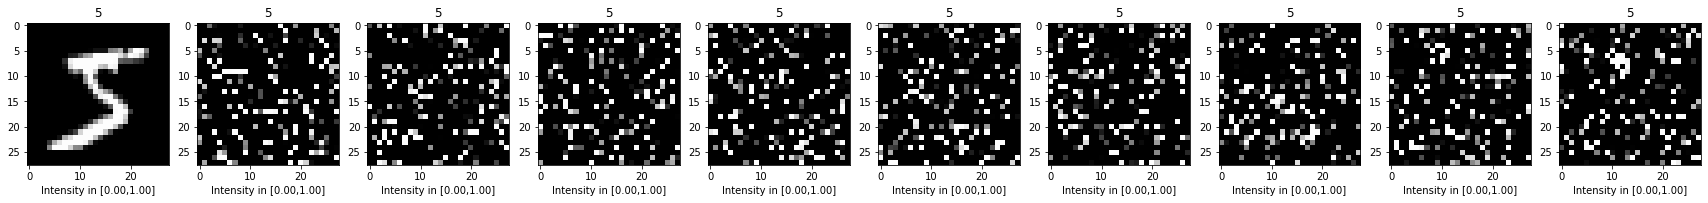

In [5]:
train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

In [6]:
## define a MLP model
model_init=mlp.MLP(input_size=input_size,output_size=output_size,
                   hidden_size=hidden_sizes,activation=activation,
                   device=device)
model_init.reset()

## First we perform SCP

In [12]:
scp_iteration = 5
scp_alpha=0.25
scp_importance_power_list = [4,5,6,7,8]
loss_scp_list = []
acc_scp_list = []

In [13]:
for i in tqdm_notebook(range(scp_iteration)):
    scp_importance = 10 ** scp_importance_power_list[i]
    ## define a MLP model
    model = copy.deepcopy(model_init).to(device)
    scp = SCP(model,device=device,alpha=scp_alpha,n_slices=20)
    ## performing training
    loss_scp, acc_scp = {}, {}
    for task in tqdm_notebook(range(num_task)):
        loss_scp[task] = []
        acc_scp[task] = []
        for _ in range(epochs):
            optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
            loss_scp[task].append(train_test_model.scp_train_classifier(scp=scp,
                                                                        optimizer=optimizer,
                                                                        data_loader=train_loader[task],
                                                                        importance=scp_importance,
                                                                        device=device))                           
            for sub_task in range(task + 1):
                acc_scp[sub_task].append(train_test_model.test_classifier(model=scp.model,
                                                                        data_loader=test_loader[sub_task],
                                                                         device=device))
        scp.consolidate(train_loader[task])    
        torch.save(scp.model.state_dict(), models_folder + 'model_scp_iteration_%d_importance_1e%d_task_%d.pt'%(iteration, scp_importance_power_list[i], task)) 

    loss_scp_list.append(loss_scp)
    acc_scp_list.append(acc_scp)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Text(0.5, 0.98, 'Using SCP Regularizer')

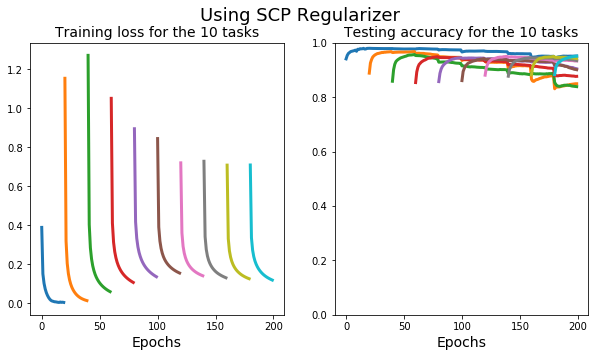

In [21]:
i=3
loss_scp = loss_scp_list[i]
acc_scp = acc_scp_list[i]
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using SCP Regularizer',fontsize=18)

In [18]:
def get_mean_acc(acc,epochs):
    num_task=len(acc)
    temp=np.zeros((num_task,len(acc[0])))
    for t,v in acc.items():
        temp[t,range(t * epochs, num_task * epochs)]=v
        if t<num_task-1:
            temp[t+1,:]=temp[:t+1,:].mean(0)
    return temp.mean(0)

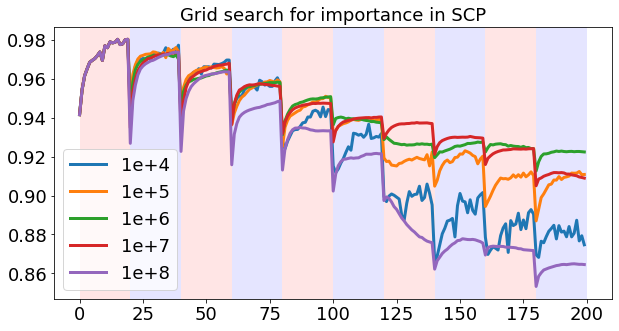

In [25]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
for i in range(scp_iteration):
    plt.plot(get_mean_acc(acc_scp_list[i],epochs),linewidth=3)
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['1e+4','1e+5','1e+6','1e+7','1e+8'],fontsize=18)
plt.title('Grid search for importance in SCP',fontsize=18)
plt.show()

## Next we perform CountSketch (on SCP)

In [7]:
sketch_scp_iteration = 5
sketch_scp_importance_power_list = [-1,0,1,2,3]
n_bucket = 10
loss_sketch_scp_list = []
acc_sketch_scp_list = []

In [9]:
for i in tqdm_notebook(range(sketch_scp_iteration)):
    sketch_scp_importance = 10 ** sketch_scp_importance_power_list[i]
    ## define a MLP model
    model = copy.deepcopy(model_init).to(device)
    sketch_scp = SketchSCP(model,device=device,alpha=0.25,n_slices=20,n_bucket=n_bucket)
    ## performing training
    loss_sketch_scp, acc_sketch_scp = {}, {}
    for task in tqdm_notebook(range(num_task)):
        loss_sketch_scp[task] = []
        acc_sketch_scp[task] = []
        for _ in range(epochs):
            optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
            loss_sketch_scp[task].append(train_test_model.scp_train_classifier(scp=sketch_scp,
                                                                        optimizer=optimizer,
                                                                        data_loader=train_loader[task],
                                                                        importance=sketch_scp_importance,
                                                                        device=device))
            for sub_task in range(task + 1):
                acc_sketch_scp[sub_task].append(train_test_model.test_classifier(model=sketch_scp.model,
                                                                         data_loader=test_loader[sub_task],
                                                                         device=device))
        sketch_scp.consolidate(train_loader[task])
        torch.save(model.state_dict(), models_folder + 'model_scp_sketched_bucket_%d_importance_1e%d_task_%d.pt'%(n_bucket, sketch_scp_importance_power_list[i], task))
    loss_sketch_scp_list.append(loss_sketch_scp)
    acc_sketch_scp_list.append(acc_sketch_scp)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

Text(0.5, 0.98, 'Using CountSketch on SCP')

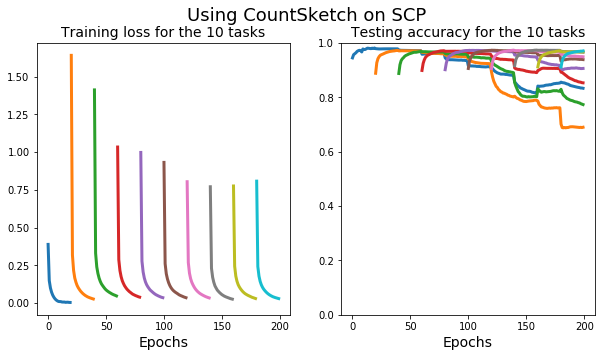

In [25]:
i=2
loss_sketch_scp = loss_sketch_scp_list[i]
acc_sketch_scp = acc_sketch_scp_list[i]
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_sketch_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using CountSketch on SCP',fontsize=18)

In [11]:
# def get_mean_acc_on_iterations(acc_list):
#     acc = {}
#     for i in acc_list[0].keys():
#         acc[i] = np.zeros(len(acc_list[0][i]))
#     for t in range(len(acc_list)):
#         for i in acc_list[0].keys():
#             acc[i] += np.array(acc_list[t][i]) / len(acc_list)
#     return acc

In [12]:
# acc_scp = get_mean_acc_on_iterations(acc_scp_list)
# acc_sketch_scp = get_mean_acc_on_iterations(acc_sketch_scp_list)

NameError: name 'acc_sketch_scp_list' is not defined

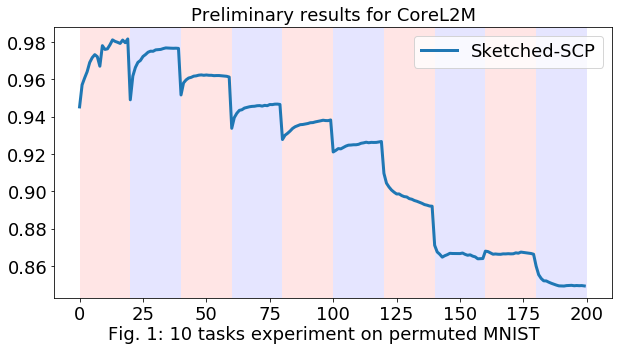

In [24]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
# plt.plot(get_mean_acc(acc,epochs),linewidth=3)
# plt.plot(get_mean_acc(acc_scp,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_sketch_scp,epochs),linewidth=3)
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['Sketched-SCP'],fontsize=18)
plt.title('Preliminary results for CoreL2M',fontsize=18)
plt.figtext(0.5, 0.01, 'Fig. 1: 10 tasks experiment on permuted MNIST', wrap=True, horizontalalignment='center', fontsize=18)
plt.show()


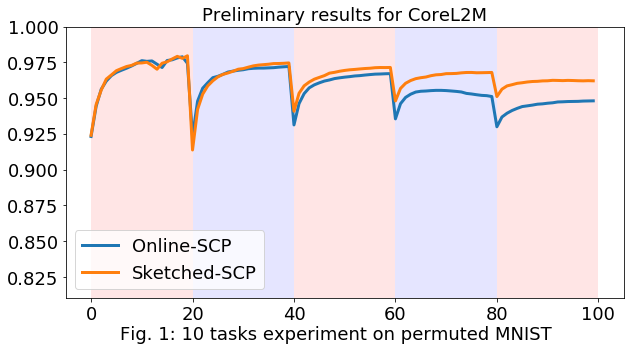

In [16]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
# plt.plot(get_mean_acc(acc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_scp,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_sketch_scp,epochs),linewidth=3)
plt.ylim(.81,1.) 
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['Online-SCP','Sketched-SCP'],fontsize=18)
plt.title('Preliminary results for CoreL2M',fontsize=18)
plt.figtext(0.5, 0.01, 'Fig. 1: 10 tasks experiment on permuted MNIST', wrap=True, horizontalalignment='center', fontsize=18)
plt.show()


In [ ]:
import pickle
pickle.dump([[loss_scp,loss_sketch_scp],
                 [acc_scp,acc_sketch_scp]],
                 open(results_folder+'experiment_scp_%d.pkl'%iteration,'wb'))